# Ce Notebook est utilisé spécialement pour la découverte et le prépocessing des data

## Importation 

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model 
from nltk.translate.bleu_score import corpus_bleu
import pickle

In [102]:
import pandas as pd

projections = pd.read_csv('../data/raw/indiana_projections.csv')
reports = pd.read_csv("../data/raw/indiana_reports.csv")

# reports.head()


print("le nombre de lignes dans le fichier de projections est de : ",projections.shape[0])
print("le nombre de lignes dans le fichier reports est de : ",reports.shape[0])

print("conclusion nous avons :",projections.shape[0],"images mais nous disposons de ",projections.shape[0]-reports.shape[0],"description d'images")

le nombre de lignes dans le fichier de projections est de :  7466
le nombre de lignes dans le fichier reports est de :  3851
conclusion nous avons : 7466 images mais nous disposons de  3615 description d'images


### Affichagedes dataset

In [103]:
print("affichage du dataset projections")
projections.head()

affichage du dataset projections


,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [104]:
pd.set_option('display.max_colwidth', None)
print("affichage du dataset reports")
reports.head(3)

affichage du dataset reports


,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size are within normal limits. There is no pulmonary edema. There is no focal consolidation. There are no XXXX of a pleural effusion. There is no evidence of pneumothorax.,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XXXX. Enlarged pulmonary arteries. Clear lungs. Inferior XXXX XXXX XXXX.,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XXXX. Pain to R back, R elbow and R rib XXXX, no previous heart or lung hx, non-XXXX, no hx ca",NaN,NaN,"No displaced rib fractures, pneumothorax, or pleural effusion identified. Well-expanded and clear lungs. Mediastinal contour within normal limits. No acute cardiopulmonary abnormality identified."


## Partie 2 : Etudes statistiques

#### Vérifions le nombre d'image commun d'isponible

In [105]:
total_unique = projections['uid'].unique()
print("Nous avons donc ",len(total_unique),"images uniques dans le dataset projections")

Nous avons donc  3851 images uniques dans le dataset projections


#### Vérifions la répartitions des nombres d'images 

{1: 446, 2: 3210, 3: 181, 4: 13, 5: 1}


Text(0, 0.5, "Nombres d'image ayant x poses")

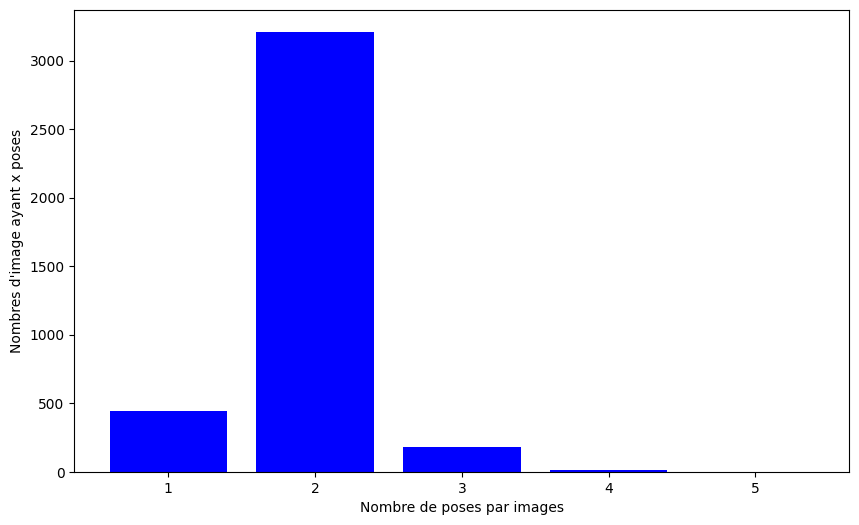

In [106]:
repartitions_images = projections['uid'].value_counts()

# Ceci est un dictionnaire qui contient le nombre d'occurence de chaque image
distribution = repartitions_images.value_counts().sort_index()

# On convertit le dictionnaire en un dictionnaire python
distribution_dict = distribution.to_dict()

print(distribution_dict)

# On affiche le nombre d'occurence de chaque image
plt.figure(figsize=(10, 6))
plt.bar(distribution_dict.keys(), distribution_dict.values(), color='blue')
plt.xlabel('Nombre de poses par images')
plt.ylabel("Nombres d'image ayant x poses")

# repartitions_images()

#### Explorations de l'image diposant plus de 5 angles

       uid                        filename projection
2426  1303  1303_IM-0199-1001-0001.dcm.png    Frontal
2427  1303  1303_IM-0199-1001-0002.dcm.png    Frontal
2428  1303  1303_IM-0199-2001-0001.dcm.png    Frontal
2429  1303  1303_IM-0199-2001-0003.dcm.png    Frontal
2430  1303  1303_IM-0199-2001-0002.dcm.png    Lateral


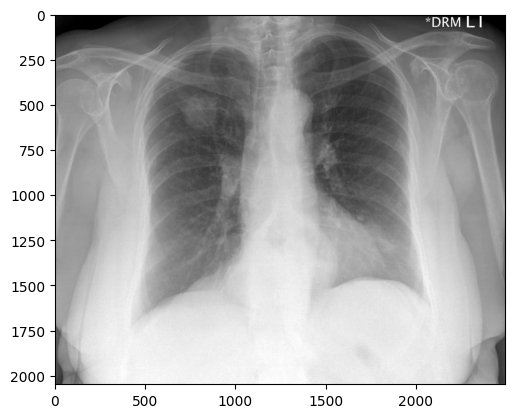

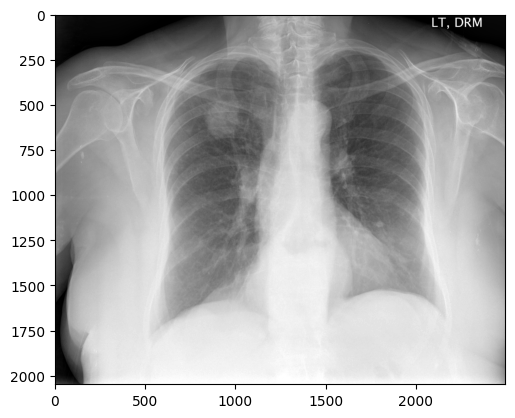

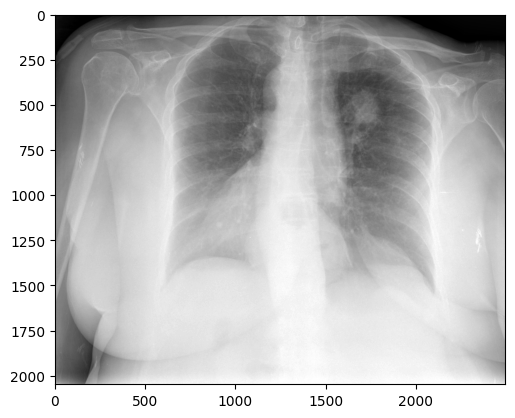

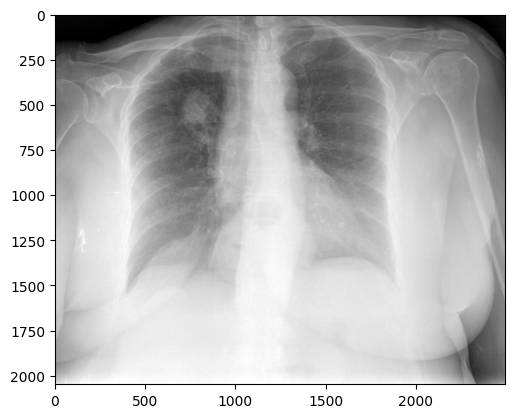

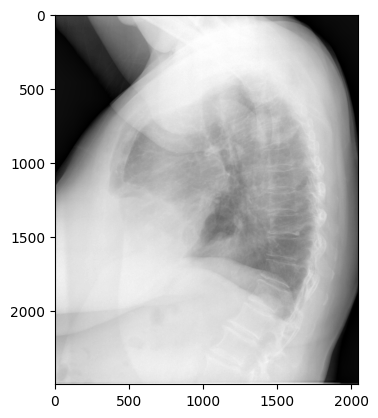

,uid,MeSH,Problems,image,indication,comparison,findings,impression
1256,1303,"Mass/lung/upper lobe/right/posterior;Opacity/heart/left;Hernia, Hiatal","Mass;Opacity;Hernia, Hiatal","CHEST 2V FRONTAL/LATERAL XXXX, XXXX XXXX PM",XXXX bleed,"XXXX, XXXX.","In the interval, a 3 cm uncalcified mass has developed in the posterior segment of the right upper lobe. In addition, on the PA view, an 8 mm opacity is adjacent to the left XXXX of the heart. This opacity cannot be well identified on the lateral view. It may be artifactual, but another mass on the left cannot be excluded. Mediastinum is normal with no evidence for adenopathy. Heart size normal. Note XXXX of an unchanged hiatal hernia.","XXXX right upper lobe mass, suspicious for neoplasm. CT of chest abdomen and head would be helpful for further evaluation."


In [107]:
pd.set_option('display.max_colwidth', None)
repartitions_images = projections['uid'].value_counts()

max_value = repartitions_images.max()


uids_with_max = repartitions_images[repartitions_images == max_value]
uid_max = uids_with_max.index[0]

# On va alors selectionner les images avec ce uid
images_max_uid = projections[projections["uid"]==uid_max]
print(images_max_uid)


for i in images_max_uid["filename"]:
    img = mpimg.imread("../data/images/" + i)
    plt.imshow(img,cmap="gray")
    plt.show()


images_max_uid_reports = reports.loc[reports["uid"]==uid_max]
images_max_uid_reports

#### Voyons voir les images ayant pas de description 

In [108]:
nan_image_caption = reports.loc[reports["findings"].isna()]

print("le nombre d'image n'ayant pas de descriptions est :",len(nan_image_caption))


le nombre d'image n'ayant pas de descriptions est : 514


Nous allons alors les supprimer

In [109]:
interim_data_set = reports.dropna(subset=["findings"])

nan_image_caption = interim_data_set.loc[interim_data_set["findings"].isna()]

print("le nombre d'image après le drop ayant pas de descriptions est :",len(nan_image_caption))


print("Longueur du dataset après le drop : ",len(interim_data_set))


# interim_data_set.to_csv("../data/interim/report_interim.csv", index=False)

le nombre d'image après le drop ayant pas de descriptions est : 0
Longueur du dataset après le drop :  3337


## Partie 3 : Travail sur les texts pour le captioning

#### Nous allons d'abord faire des fonction pour le prepocessing

In [110]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

def text_to_lower(text):
    return text.lower()

# def remove_numbers(text):
#     return re.sub(r'\d+', '', text)

def remove_extra_spaces(text):
    return re.sub(' +', ' ', text)


stop_words = stopwords.words('english')
stop_words.remove('no')
def remove_stop_words(text):
    list_without_stop_word = ([word for word in text.split() if word not in stop_words])
    
    return " ".join(list_without_stop_word)


def remove_xxxx_pattern(text):
    return re.sub(r'xxxx', '', text)

def clean_text(text):
    text = text_to_lower(text)
    text = remove_punctuation(text)
    text = remove_extra_spaces(text)
    text = remove_stop_words(text)
    text = remove_xxxx_pattern(text)
    
    return text

Application des fonctions de prepocessing

32
14


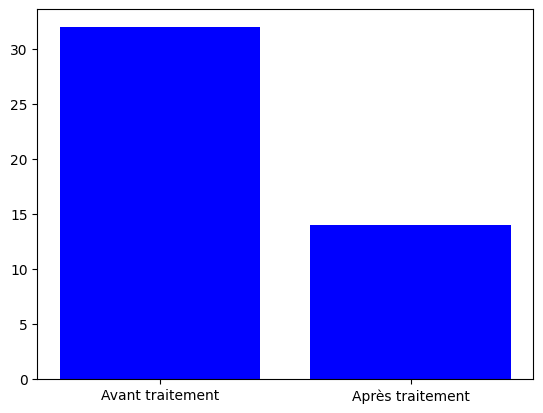

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,start cardiac silhouette mediastinum size within normal limits no pulmonary edema no focal consolidation no pleural effusion no evidence pneumothorax end,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,start borderline cardiomegaly midline sternotomy enlarged pulmonary arteries clear lungs inferior end,No acute pulmonary findings.


In [111]:
interim_data_set = pd.read_csv("../data/interim/report_interim.csv")
initial_data_set = pd.read_csv("../data/raw/indiana_reports.csv")

# Prenons les data avant le pre-processing
exemple_1 = initial_data_set["findings"].iloc[5].split()
print(len(exemple_1))

interim_data_set["findings"] = interim_data_set["findings"].apply(clean_text)
exemple_2 = interim_data_set["findings"].iloc[5].split()
print(len(exemple_2))


plt.bar(["Avant traitement","Après traitement"],[len(exemple_1),len(exemple_2)],color="blue")
plt.show()
# Faisons une petite comparaison avant et après le nettoyage


interim_data_set.head(2)

# interim_data_set.to_csv("../data/interim/report_interim.csv", index=False)

#### On va maintenant ajouter sur chaque caption les mots "start" "end" pour guider le model

In [112]:
def add_start_end_token(text):
    return "<start> " + text + " <end>"


interim_data_set["findings"] = interim_data_set["findings"].apply(add_start_end_token)

# interim_data_set.to_csv("../data/interim/report_interim.csv", index=False)

interim_data_set.head(2)

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,<start> start cardiac silhouette mediastinum size within normal limits no pulmonary edema no focal consolidation no pleural effusion no evidence pneumothorax end <end>,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,<start> start borderline cardiomegaly midline sternotomy enlarged pulmonary arteries clear lungs inferior end <end>,No acute pulmonary findings.


## Partie 4 : Fonctions pour extraire les features combinée avec le resize

#### Resizing de tous les image en 299x299x3 soit 2048 vecteurs de features

In [113]:
def resize_image(image):
    return cv2.resize(image, (299, 299)) 

#### Fonction pour l'extraction des features avec le model tf.keras.applications.Xception

In [114]:
model = tf.keras.applications.Xception(
    include_top=False, 
    pooling="avg"
)

In [115]:
def extract_features(image_path):
    image = cv2.imread(image_path)
    image = resize_image(image)
    image = np.expand_dims(image, axis=0)

    image = image/127.5
    image = image - 1.0
    # feature = model.predict(image) 
    
    feature = model.predict(image, verbose=0)
       
    return feature

Test de la fonction feature extraction

In [116]:
# Test de la fonction extract_features
image_path = "../data/images/1_IM-0001-3001.dcm.png"
image = cv2.imread(image_path)
im = cv2.rotate(image,cv2.ROTATE_90_CLOCKWISE)
feature = extract_features(image_path)

print(feature)
print(len(feature[0]))

[[0.00728106 0.45409667 0.05739988 ... 0.08157095 0.11934612 0.08800451]]
2048


Récupération des features et sauvegarde dans un fichier .npy

In [117]:
# tf.keras.config.disable_interactive_logging()
# def save_features(data_set):
#     features_dict = {} 

#     for _, data in tqdm(data_set.iterrows()):
#         image_path = "../data/images/" + data["filename"]
        
#         try:
#             feature = extract_features(image_path) 
#             features_dict[image_path] = feature  
#         except Exception as e:
#             print(f"⚠️ Erreur lors de l'extraction des features pour {image_path}: {e}")
    
#     np.save("../data/features/feature.npy", features_dict)
    
#     return features_dict
    
# # Appel de la fonction
# projections = pd.read_csv('../data/interim/projection_interim.csv')
# save_features(projections)

## Partie 5 : data augmentation sur les images avec un nombre de uid < 1

Le principe du data augmentation c'est de faire des rotations sur une images (+/- [-15,15]) afin de pas trop affecté le model tout en enrichissant notre dataset

Etape 1 : Récupérations de tous ces images

In [118]:
# On va d'abord enlever les images sans description dans le projection file

projection_init = pd.read_csv("../data/raw/indiana_projections.csv")
reports_init = pd.read_csv("../data/raw/indiana_reports.csv")

nan_image_caption_uid = reports_init.loc[reports_init["findings"].isna()]["uid"] 
projection_init_no_nan = projection_init[~projection_init["uid"].isin(nan_image_caption_uid)]

# projection_init_no_nan.to_csv("../data/interim/projection_interim.csv", index=False)

In [119]:
projection_interim = pd.read_csv("../data/interim/projection_interim.csv")

projection_uid_values_count = projection_interim["uid"].value_counts()
projection_uid_values_count

# Maintenant on va récupérer tous les uid qui ont comme valeur 1 dans le dataset projection_interim
uid_values_1 = projection_uid_values_count[projection_uid_values_count == 1].index.to_list()

# recupérons le dataset des uid_1 
projection_uid_1 = projection_interim[projection_interim["uid"].isin(uid_values_1)]
projection_uid_1

,uid,filename,projection


In [120]:
def rotate_image(image, angle):
    (h, w) = image.shape[:2] 
    center = (w // 2, h // 2) 

    # Rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Appliquer la rotation
    rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

def data_augmentation(data_uid_1):
    projection_interim = pd.read_csv("../data/interim/projection_interim.csv")
    
    for _, data in data_uid_1.iterrows():
        image_path = data["filename"]
        image = cv2.imread("../data/images/" + image_path)
        
        value_rotate = np.random.randint(-15, 15) 
        if value_rotate in np.arange(-5, 6):
            value_rotate = 10
            
        image_rotate = rotate_image(image, value_rotate)
        
        # On sauvegarde l'image augmentée
        new_filename = image_path + "_augmented.png"
        cv2.imwrite("../data/images/" + new_filename, image_rotate)

        # On ajoute la nouvelle entrée dans projection_interim
        new_row = pd.DataFrame([{"uid": data["uid"], "filename": new_filename, "projection": data['projection']}])
        projection_interim = pd.concat([projection_interim, new_row], ignore_index=True)
    
    return projection_interim

# Application du data augmentation 
# data = data_augmentation(projection_uid_1)

# data


Verifions si tout est OK maintenant 

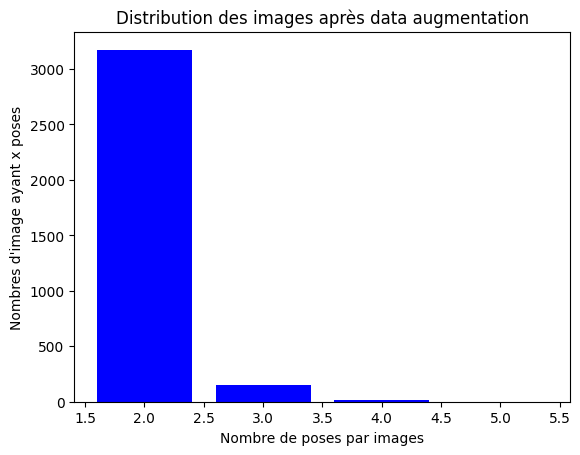

In [121]:
data = pd.read_csv("../data/interim/projection_interim.csv")
data_counts = data.value_counts("uid")

data_counts = data_counts.value_counts().to_dict()

data_counts

# Affichage en plot

plt.bar(data_counts.keys(), data_counts.values(), color='blue')
plt.title("Distribution des images après data augmentation")
plt.xlabel('Nombre de poses par images')
plt.ylabel("Nombres d'image ayant x poses")
plt.show()


# data.to_csv("../data/interim/projection_interim.csv", index=False)

## Partie 6 : vectorisation des captions

#### Nous allons vectorizer nos description avec TextVectorization de tensorflow

In [122]:
interim_data_set = pd.read_csv("../data/interim/report_interim.csv")

captions_column = interim_data_set["findings"]

def recover_all_captions(captions_column):
    all_captions = []
    for caption in captions_column:
        all_captions.append(caption)
    return all_captions


all_captions = recover_all_captions(captions_column)

print(len(all_captions))


# On va alors créer un tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
diction = tokenizer.word_index
print(diction)

# On peut voir alors les phrases tokenizées
sequences = tokenizer.texts_to_sequences(all_captions)
print(sequences)


print(diction['end'])


# Sauvegarde du tokenizer sous format .pkl

# with open("../data/Process/tokenizer.pkl", "wb") as f:
#     pickle.dump(tokenizer, f)
    
    
# with open("../data/Process/tokenizer.pkl", "rb") as f:
#     moussa = pickle.load(f)
    

3337
{'no': 1, 'normal': 2, 'end': 3, 'start': 4, 'pleural': 5, 'pneumothorax': 6, 'effusion': 7, 'heart': 8, 'lungs': 9, 'size': 10, 'focal': 11, 'within': 12, 'clear': 13, 'limits': 14, 'pulmonary': 15, 'consolidation': 16, 'silhouette': 17, 'right': 18, 'mediastinal': 19, 'airspace': 20, 'cardiomediastinal': 21, 'left': 22, 'acute': 23, 'lung': 24, 'stable': 25, 'spine': 26, 'disease': 27, 'changes': 28, 'unremarkable': 29, 'mediastinum': 30, 'structures': 31, 'thoracic': 32, 'contours': 33, 'bony': 34, 'contour': 35, 'degenerative': 36, 'large': 37, 'mild': 38, 'without': 39, 'seen': 40, 'appear': 41, 'osseous': 42, 'cardiac': 43, 'calcified': 44, 'opacity': 45, 'vascularity': 46, 'effusions': 47, 'intact': 48, 'abnormality': 49, 'evidence': 50, 'visualized': 51, 'upper': 52, 'opacities': 53, 'vasculature': 54, 'lateral': 55, 'noted': 56, 'aorta': 57, 'chest': 58, 'lobe': 59, 'identified': 60, 'bilaterally': 61, 'lower': 62, 'air': 63, 'volumes': 64, 'present': 65, 'atelectasis': 6

## Partie 6 : Creation d'un data générator 

Nous allons d'abord récupérer toutes les variables qui nous seront utiles par la suite

In [123]:
max_length = max([len(seq) for seq in sequences])
print(max_length)

105


In [124]:
def data_generator(descriptions_df_path, projection_df_train, feature_path, tokenizer, max_length, vocab_size, batch_size=32):
    descriptions_df = pd.read_csv(descriptions_df_path)
    features = np.load(feature_path, allow_pickle=True).item()
    
    while True:
        x_1, x_2, y = list(), list(), list()
        for _, projection in projection_df_train.iterrows():
            image_path = projection["filename"]
            image_uid = projection["uid"]
            feature = features["../data/images/" + image_path]
            
            desc_image = descriptions_df[descriptions_df["uid"] == image_uid]["findings"].tolist()
            desc_image = desc_image[0]
            
            seq = tokenizer.texts_to_sequences([desc_image])[0]  

            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]  
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                x_1.append(feature)  
                x_2.append(in_seq)  
                y.append(out_seq)  

                if len(x_1) == batch_size:
                    # Modification ici : renvoyer un tuple (inputs, targets)
                    yield (np.array(x_1).squeeze(axis=1), np.array(x_2)), np.array(y)

                    x_1, x_2, y = list(), list(), list()

Test de la fonction data_generator

In [125]:
descriptions_df_path = "../data/interim/report_interim.csv"
projection_df_path = "../data/interim/projection_interim.csv"
projection_df = pd.read_csv(projection_df_path)
feature_path = "../data/features/feature.npy"
vocab_size = len(tokenizer.word_index) + 1
max_length = max_length
batch_size = 32

train_data_generator = data_generator(descriptions_df_path, projection_df, feature_path, tokenizer, max_length, vocab_size)

[x_1,x_2] , y  = next(train_data_generator)

print(x_1.shape)


(32, 2048)


## Partie 7 : Model Construction 

In [126]:
def define_model(vocab_size, max_length):
    # features from the CNN model compressed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1 )
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # merge it [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='models/model.png', show_shapes=True)
    return model

## Partie 8 : Training the model 

Chargement des paramètre utiles

In [127]:
descriptions_df_path = "../data/interim/report_interim.csv"
projection_df_path = "../data/interim/projection_interim.csv"
projection_df = pd.read_csv(projection_df_path)
feature_path = "../data/features/feature.npy"
vocab_size = len(tokenizer.word_index) + 1
max_length = max_length
batch_size = 32
epochs = 20


On va split notre dataset d'abord 

In [128]:
train_projections = projection_df.sample(frac=0.85, random_state=0)
test_projections = projection_df.drop(train_projections.index)


# train_projections.to_csv("../data/Process/train.csv")
# test_projections.to_csv("../data/Process/test.csv")

print(len(train_projections))
print(len(test_projections))

5823
1028


In [129]:
# steps = len(train_projections) // batch_size

# model  = define_model(vocab_size, max_length)

# for i in range(epochs):
#     train_data_generator = data_generator(descriptions_df_path, train_projections, feature_path, tokenizer, max_length, vocab_size, batch_size)
#     model.fit(train_data_generator, epochs=1, steps_per_epoch=steps, verbose=1)


Sauvegarde du model 

In [130]:
# model.save("../models/model.keras")

## Partie 9 : Evaluation du model 

Pour le test Nous allons utiliser le BLUE Score

In [4]:
# On va alors tester le modèle
def predict_caption(model, image, tokenizer, max_length=105):
    # add start tag for generation process
    caption = '<start> '
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([caption])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        output = model.predict([image, sequence], verbose=0)
        # get index with high probability
        index = np.argmax(output)
        # convert index to word
        word = tokenizer.index_word[index]
        # stop if we cannot map the word 
        if word is None:
            break
        # append as input for generating next word
        
        if word == 'end':
            caption = caption + ' ' + '<end>'
            break
        
        caption = caption + ' ' + word
    return caption

Nous allons commencer par écrire la fonction

In [35]:
def eval_func(model_path,path_data,feature_path,tokenizer_path):
    
    # List pour le stockage des descriptions
    all_predict_captions = list()
    all_real_captrions = list()
    
    # Loading all data
    with open("../data/Process/tokenizer.pkl", "rb") as f:
        tokenizer = pickle.load(f)
    
    data_projection =  pd.read_csv(path_data)
    data_description = pd.read_csv("../data/interim/report_interim.csv")
    features = np.load(feature_path, allow_pickle=True).item()
    model = load_model(model_path)
    
    
    for state,row in tqdm(data_projection.iterrows()) :
        
        image_path = "../data/images/" +  row['filename']
        image_feature = features[image_path]
        
        description_predit = predict_caption(model,image_feature,tokenizer)
        
        # Récupération de la description normal : 
        description_reel = data_description.loc[data_description['uid'] == row['uid'], 'findings'].values[0]

        
        all_predict_captions.append(description_predit.split())
        
        all_real_captrions.append([description_reel.split()])
        
        
        # if (state == 500 ) :
        #     break
        
    blue_score = corpus_bleu(all_real_captrions,all_predict_captions)
    
        # return (description_predit,description_reel)
    return blue_score
        
        

Test de la fonction

In [36]:
path_data = "../data/Process/test.csv"
model_path = "../models/model.keras"
feature_path = "../data/features/feature.npy"
tokenizer_path = "../data/Process/tokenizer.pkl"

# predict,real = eval_func(
#     model_path= model_path,
#     path_data=path_data,
#     feature_path=feature_path,
#     tokenizer_path=tokenizer_path
#     )
# print("--------description reel------ \n")
# print(real ,"\n")
# print("--------description prédit------ \n")
# print(predict)


blue_score = eval_func(
    model_path= model_path,
    path_data=path_data,
    feature_path=feature_path,
    tokenizer_path=tokenizer_path
    )


blue_score

/Users/macbookpro/miniconda3/envs/sign_langage/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
0it [00:00, ?it/s]/Users/macbookpro/miniconda3/envs/sign_langage/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_layer_29', 'input_layer_30']. Received: the structure of inputs=('*', '*')
  warnings.warn(
1028it [13:23,  1.28it/s]


0.07095782808990228

In [41]:
model_path = "../models/model.keras"

model = load_model(model_path)

model.summary()
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 105)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_29      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_12        │ (None, 105, 256)  │    420,352 │ input_layer_30[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 2048)      │          0 │ input_layer_29[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 105, 256)  │          0 │ embedding_12[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_12        │ (None, 105)       │          0 │ input_layer_30[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 256)       │    524,544 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 256)       │    525,312 │ dropout_25[0][0], │
│                     │                   │            │ not_equal_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_72 (Add)        │ (None, 256)       │          0 │ dense_36[0][0],   │
│                     │                   │            │ lstm_12[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_37 (Dense)    │ (None, 256)       │     65,792 │ add_72[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, 1642)      │    421,994 │ dense_37[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,915,990 (14.94 MB)

 Trainable params: 1,957,994 (7.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,957,996 (7.47 MB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.
